In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from scipy.stats import poisson

In [2]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = 10 + np.random.uniform(0, 10, (B, 1))
    competitor_prices = 10 + np.random.uniform(0, 10, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    
    # Y = (our_rank == 0).astype(int).ravel()
    Y = np.maximum(0, (3 - our_rank)).astype(int).ravel()
    # Y = np.round(np.random.uniform(0, 1, our_rank.shape) * (1 - our_rank / 11)).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

In [3]:
# Train sales probability model
def make_model(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    def predict(x):
        return np.maximum(0, regr.predict(x))
        # return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


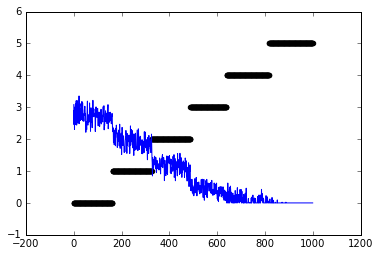

In [4]:
# Plot sales probability model
X_train, _ = generate_train_data(1000)
X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 6], color='black')
plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

plt.show()

In [9]:
def rank(a, p):
    _rank = p.shape[0]
    for i in range(p.shape[0]):
        if a < p[i]:
            _rank = _rank - 1
    return _rank

def sales_prob(price, options):
    x = np.hstack((price, options.competitor_prices, rank(price, options.competitor_prices))).reshape(1, -1)
    return sales_model(x)[0]


def _V(price, t, n, options):
    p = sales_prob(price, options)
    _sum = 0
    for i in range(int(poisson.ppf(0.9999, p)) + 1):
        if i > n:
            return 0
        pi = poisson.pmf(i, p)
        today_profit = min(n, i) * price
        holding_costs = n * options.L
        _, V_future = V(t + 1, max(0, n - i), options)
        exp_future_profits = options.delta * V_future
        _sum += pi * (today_profit - holding_costs + exp_future_profits)
    return _sum

def V(t, n, options):
    if (t,n) in options.cache:
        return options.cache[t,n]
    if t >= options.T:
        options.cache[t,n] = (0, n * options.Z)
        return (0, n * options.Z)
    if n <= 0:
        options.cache[t,n] = (0, 0)
        return (0, 0)

    V_opt = -100000
    price_opt = -100000
    for price in options.price_range:
        v = _V(price, t, n, options)
        if v > V_opt:
            V_opt = v
            price_opt = price
            
    options.cache[t,n] = (price_opt, V_opt)
    return (price_opt, V_opt)


class PriceOptimizer():
    def __init__(self, sales_model, competitor_prices,
               T=20, N=15, 
               price_range=np.arange(10, 20, 1), 
               L=0.01, delta=0.99, Z=0.5):
        self.sales_model = sales_model
        self.competitor_prices = competitor_prices
        self.T = T
        self.N = N
        self.price_range = price_range
        self.L = L
        self.delta = delta
        self.Z = Z
        self.cache = {}

    def run(self, t, n):
        return V(t, n, self)

In [10]:
def simulation(sales_model, competitor_prices, T=20, N=15):
    n = N
    
    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]
   
    price_history = []
    accumulated_sales = []
    
    profit = 0
    L=0.01
    Z=0.5

    optimizer = PriceOptimizer(sales_model, competitor_prices, N=N, T=T, L=L, Z=Z)
    
    for t in range(0, T):
        price, V = optimizer.run(t, n)
        if t == 0:
            print("Estimated profit: {0}".format(V))
        price_history.append(price)
        pi = sales_prob(price)
        sales = min(n, np.random.poisson(pi))
        n = n - sales
        profit += price * sales - L * n
        accumulated_sales.append(N - n)
        # print(t, n, price, pi, competitor_prices, rank(price, competitor_prices))
        
        # # Change competitor prices
        # competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        # optimizer = PriceOptimizer(sales_model, competitor_prices, N=n, T=T, L=L, Z=Z)
    
    # Realize salvage profits
    profit += n * Z    
    print("Simulated profit: {0}".format(profit))
    
    plt.plot(price_history)    
    plt.ylabel('Price Path')
    plt.show()
    
    plt.plot(accumulated_sales)    
    plt.ylabel('Accumulated Sales')
    plt.show()

    return profit

# competitor_prices_simulation = 16 + np.random.uniform(0, 4, 5)
# simulation(sales_model, competitor_prices_simulation)

Estimated profit: 155.4345963333737
Simulated profit: 155.52


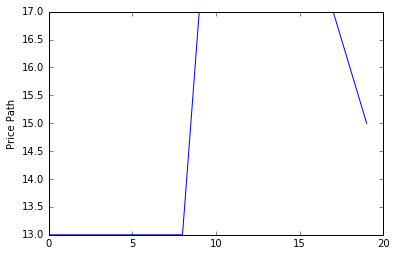

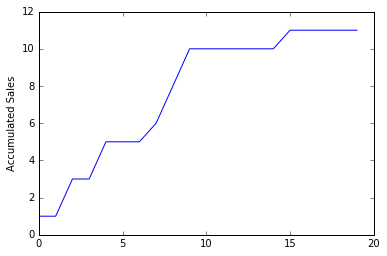

Estimated profit: 155.4345963333737
Simulated profit: 182.53


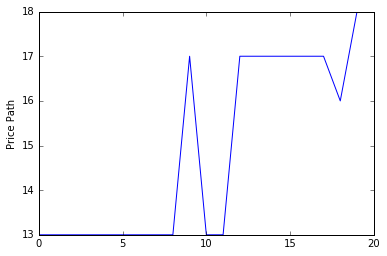

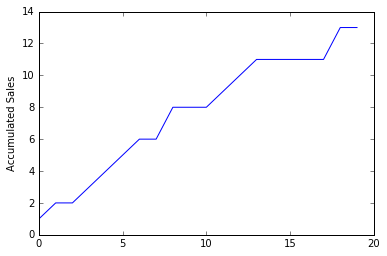

Estimated profit: 155.4345963333737
Simulated profit: 164.92


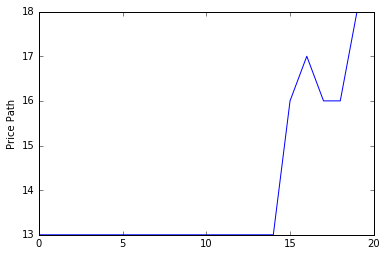

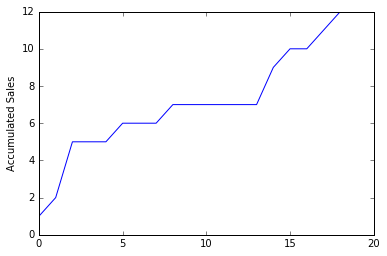

Estimated profit: 155.4345963333737
Simulated profit: 168.35999999999987


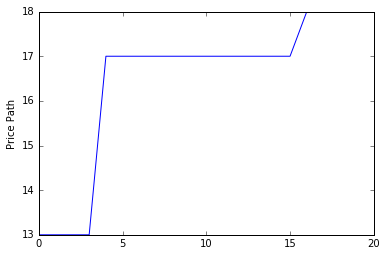

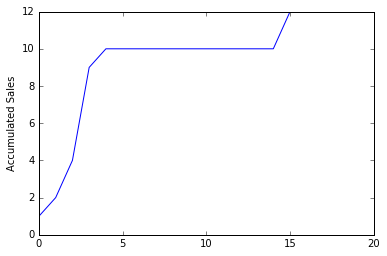

Estimated profit: 155.4345963333737
Simulated profit: 164.15


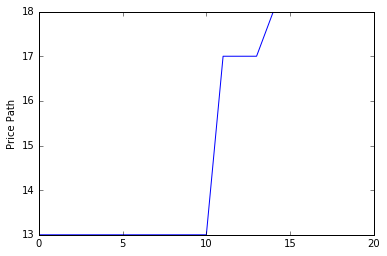

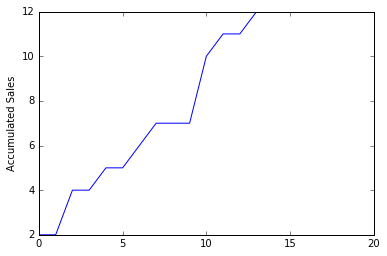

Estimated profit: 155.4345963333737
Simulated profit: 172.1


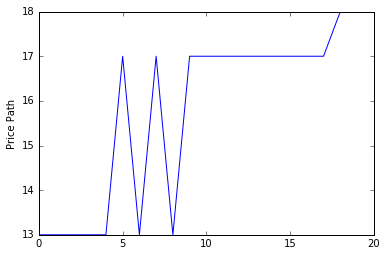

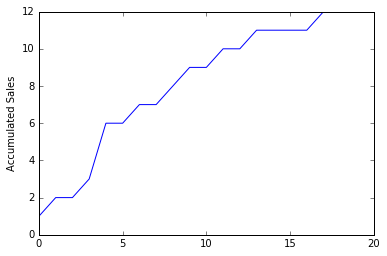

In [ ]:
competitor_prices = 10 + np.random.uniform(0, 10, 5)
profits = [simulation(sales_model, competitor_prices) for i in range(0, 20)]
    
n, bins, patches = plt.hist(profits, 10, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Profit')
plt.ylabel('Probability')
plt.show()